In [26]:
# Imports
%matplotlib notebook
# numpy, matplotlib, seaborn and matplotlib
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# define data path
INPUT_PATH = "../data/%s.csv"
# define small samples to quickly explore data
read_rows = 3000;

# overview part
This part is to overview the first N rows of the sample to get initial feeling of the dataset

In [44]:
# load data head for overview
train_date_overview = pd.read_csv('../data/train_date.csv',nrows = read_rows)
train_categorical_overview = pd.read_csv('../data/train_categorical.csv',nrows = read_rows)
train_numeric_overview = pd.read_csv('../data/train_numeric.csv',nrows = read_rows)
test_categorical_overview = pd.read_csv('../data/test_categorical.csv', nrows = read_rows)
test_date_overview = pd.read_csv('../data/test_date.csv', nrows = read_rows)
test_numeric_overview = pd.read_csv('../data/test_numeric.csv', nrows = read_rows)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,204,206,210,212,216,218,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,335,407,410,413,416,419,422,425,428,431,434,437,440,443,446,449,452,455,458,461,464,467,470,473,476,479,482,485,488,491,494,497,500,503,506,509,512,515,518,611,614,617,620,623,626,629,632,635,638,641,644,647,650,653,656,659,662,665,668,671,674,677,680,683,686,689,692,695,698,701,704,707,710,713,716,719,722,1005,1007,1008,1010,1011,1013,1014,1016,1017,1019,1020,1022,1023,1025,1026,1028,1029,1031,1032,1034,1035,1037,1038,1040,1041,1043,1044,1046,1047,1049,1050,1052,1126,1129,1132,1135,1138,1141,1144,1147,1183,1185,1188,1191,1194,1197,1200,

In [29]:
#train_numeric_overview
#train_categorical_overview
#train_date_overview
#test_numeric_overview
#test_categorical_overview
#test_date_overview 

# Numeric Feature Exploration Part
This part is to explore the numericial feature dataset

In [30]:
# function to calculate failure rate
def get_failure_rate(file_name):
    # will calculate the error rate from data on the file based on response col
    # Respons: 1 = Failed QC , 0 = Passed QC
    rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Response"])
    failure_rate = rows[rows.Response == 1].size / float(rows[rows.Response == 0].size)
    return failure_rate

In [31]:
# function to calculate data size in 6 dataset
def explore_data_size():
    # explore the size (rows, cols) of each file
    data_files = ['train_numeric', 'train_date', 'train_categorical', 'test_numeric',
                  'test_date', 'test_categorical']
    stats = []
    for file_name in data_files:
        cols = pd.read_csv(INPUT_PATH % file_name, nrows=1)
        rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Id"])
        stats.append({'File': file_name, 'Rows': rows.shape[0], 'Columns': cols.shape[1]})
    # convert the result into a DataFrame so we can do plotting.
    df = pd.DataFrame(stats, columns=["File", "Rows", "Columns"])
    failure_rate = get_failure_rate('train_numeric')
    df["Error"] = 0
    df.loc[df.File == 'train_numeric', 'Error'] = failure_rate
    return df

In [32]:
# Get data size
explore_data_size()

,File,Rows,Columns,Error
0,train_numeric,1183747,970,0.005845
1,train_date,1183747,1157,0.000000
2,train_categorical,1183747,2141,0.000000
3,test_numeric,1183748,969,0.000000
4,test_date,1183748,1157,0.000000
5,test_categorical,1183748,2141,0.000000


This part is to explore how many stations, lines, and features per station and per line?

In [38]:
def get_features(feature_list):
    # function to group features by station or line of production sinc the convention is:
    # L1_S15_F232 means Line 1, Station 15, Feature 232
    line_features = {}
    station_features = {}
    lines = set([item.split('_')[0] for item in feature_list])
    stations = set([item.split('_')[1] for item in feature_list])

    for l in lines:
        line_features[l] = [item for item in feature_list if '%s_' % l in item]

    for s in stations:
        station_features[s] = [item for item in feature_list if '%s_' % s in item]

    return (line_features, station_features)

In [39]:
def explore_features(data_set_name):
    # how many units processed in each station
    # also percentage of failed/passed QS in each station
    features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    line_features, station_features = get_features(features)
    # create a dataframe cols: station, features_count
    sdf = pd.DataFrame(list({int(key[1:]): len(station_features[key]) for
                             key in station_features.keys()}.items()),
                       columns=["Station", "FeatureCount"])
    ldf = pd.DataFrame(list({int(key[1:]): len(line_features[key]) for
                             key in line_features.keys()}.items()),
                       columns=["Line", "FeatureCount"])
    
    stations_plot = sdf.plot(x="Station", y="FeatureCount", kind="bar",
                             title="Fig.1 - Features by Station",
                             figsize=(13,6), fontsize=12)
    
    line_features_plot = ldf.plot(x="Line",y="FeatureCount", kind="bar",
                             title="Fig.2 - Features by line",
                             figsize=(13,6), fontsize=12)
    
    return line_features, station_features

<IPython.core.display.Javascript object>


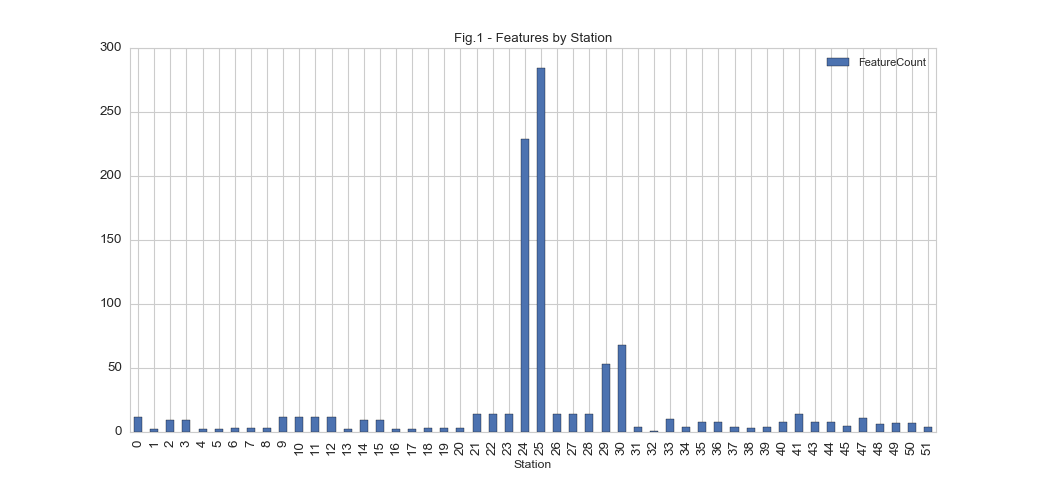

<IPython.core.display.Javascript object>


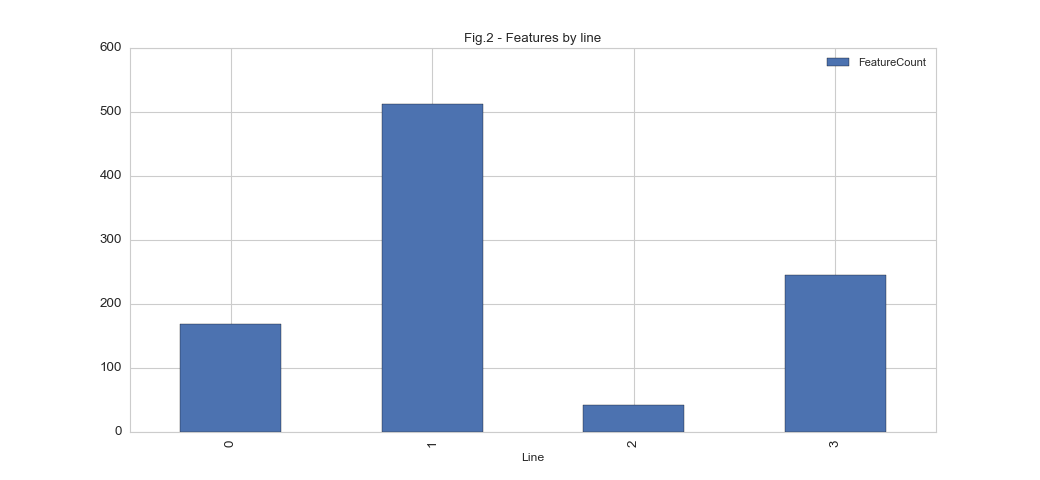

In [40]:
lf, sf = explore_features("train_numeric")

In [47]:
#continue to explore

In [52]:
a = [item for item in sf]

TypeError: 'builtin_function_or_method' object has no attribute '__getitem__'

In [48]:
def explore_product_by_station(data_set_name,read_rows):
    # need to see how many product per station
    # features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    # line_features, station_features = get_features(features)
    station_features = sf
    dwb_result = []
    ppbs_result = []
    rows = 0
    # inside this loop we will try to calculate different data sets, this way we only read the
    # files once since it takes a while and produce multiple results
    for station in station_features:
        station_data = pd.read_csv(
            INPUT_PATH % data_set_name,
            usecols=station_features[station] + ['Id', 'Response'],nrows = read_rows)
        
        # need to get how many rows in the sample row
        if not rows:
            rows = station_data.shape[0]
        # need to store how many processed units in each station
        # only if all features in that station has value we conside unit processed in this station
        ppbs_result.append(
            {'Station': int(station[1:]),
             'Processed': station_data[station_features[station]].isnull().all(axis=1).sum()})
        
        # data without blanks (dwb): take all rows and drop any row that has any blank
        # in any station column
        dwb = station_data.dropna(how="any")
        dwb_result.append([int(station[1:]), dwb.shape[0],
                       dwb[dwb["Response"] == 1].shape[0],
                       dwb[dwb["Response"] == 0].shape[0]])
        
    # convert list to a dataframe and prepare for the plot
    dwb_df = pd.DataFrame(
        dwb_result, columns=["Station", "Count", "Failed", "Passed"]).sort_values(by=["Station"])
    # calculate the error rate for each station
    dwb_df["Error"] = dwb_df.apply(lambda row: float(row["Failed"]) / row["Passed"], axis=1)
    
    # plot the stacked bar tot product/ station
    my_plot = dwb_df[["Station", "Failed", "Passed"]].plot(kind="bar", stacked=True, x="Station",
        title="Fig:3 - Products by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Stations")
    my_plot.set_ylabel("Record Count")
    
    # plot error rate per station
    my_plot = dwb_df[["Station", "Error"]].plot(
        kind="bar", x="Station",
        title="Fig:4 - Error by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Stations")
    my_plot.set_ylabel("Error %")
    
    # process the ppbs result to see how many products has been process by each station.
    ppbs_df = pd.DataFrame(
        ppbs_result, columns=['Station', 'Processed']).sort(columns=['Station'])
    # calculate the missed product for each station: all count - processed count
    ppbs_df["Missed"] = ppbs_df["Processed"].apply(lambda x: rows - x)
    # the plot
    ppbs_df.plot(x="Station", kind="bar", stacked=True,
            title="Fig: 5 - Products processed by each station",
            figsize=(13,6), fontsize=12)
    



In [50]:
explore_product_by_station("train_numeric",3000)

ZeroDivisionError: ('float division by zero', u'occurred at index 33')

In [ ]:
# start to explore categorial data

In [263]:
train_categorical = pd.read_csv('data/train_categorical.csv',nrows = 3000)

In [264]:
del train_categorical['Id']

In [265]:
train_categorical_zeroes = train_categorical.fillna(0)

In [269]:
train_categorical_zeroes = train_categorical_zeroes.values

In [271]:
np.unique(train_categorical_zeroes[train_categorical_zeroes!=0.0])

array(['T-2147482816', 'T1', 'T128', 'T1310', 'T1372', 'T143', 'T145',
       'T16', 'T16777232', 'T16777557', 'T2', 'T256', 'T3', 'T4', 'T5',
       'T512', 'T65536', 'T786432', 'T8'], dtype=object)

In [253]:
# train_categorical_zeroes_array_row = train_categorical_zeroes.values[9,:]

array(['T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1'], dtype=object)

In [277]:
train_categorical_zeroes_array_row[train_categorical_zeroes_array_row!=0.0].size/float(train_categorical_zeroes_array_row .size)

0.029439252336448597

In [285]:
a={'4':0,'6':0,'7':0.029439252336448597*100,'9':100*0.029439252336448597,'11':100*0.029439252336448597,'13':100*0.029439252336448597,'14':0.029439252336448597,
  '16':100*0.05700934579439252,'18':100*0.029439252336448597,'23':100*0.029439252336448597}

In [286]:
df_a = pd.DataFrame(a, columns = ['4', '6', '7', '9', '11', '13','14','16','18','23'],index=['0'])

# df = pd.DataFrame(raw_data, columns = ['first_name', 'last_name', 'age', 'female', 'preTestScore', 'postTestScore'])

In [287]:
df_a

,4,6,7,9,11,13,14,16,18,23
0,0,0,2.943925,2.943925,2.943925,2.943925,0.029439,5.700935,2.943925,2.943925


<IPython.core.display.Javascript object>


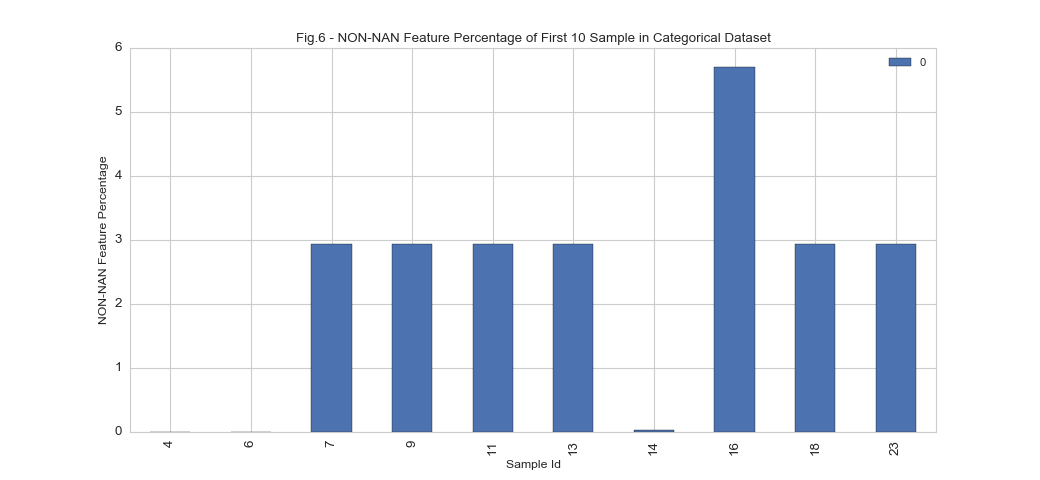

In [294]:
ax = df_a.transpose().plot( kind="bar",
                             title="Fig.6 - NON-NAN Feature Percentage of First 10 Sample in Categorical Dataset",
                             figsize=(13,6), fontsize=12)
ax.set_xlabel("Sample Id")
ax.set_ylabel("NON-NAN Feature Percentage")

In [260]:
sdf.plot(x="Station", y="FeatureCount", kind="bar",
                             title="Fig.4 - Features by Station",
                             figsize=(13,6), fontsize=12)

KeyError: 'Sample'

In [190]:
train_categorical_zeroes_array[train_categorical_zeroes_array!=0.0]

array(['T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1',
       'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T

In [191]:
np.unique(train_categorical_zeroes_array[train_categorical_zeroes_array!=0.0])

array(['T1', 'T145', 'T3'], dtype=object)

In [192]:
train_categorical_hd = pd.read_csv('data/train_categorical.csv',nrows = 10)

In [239]:
def exploreNoValuePart():
    noValue = []
    pd.read_csv('data/train_categorical.csv',nrows = 10)
    #   del train_categorical['Id']
    train_categorical_zeroes = train_categorical.fillna(0)
    train_categorical_zeroes_array = train_categorical_zeroes.values
    for i in range(10):
        train_categorical_zeroes_array_row = train_categorical_zeroes_array[i,:]
        noValue[i] = (train_categorical_zeroes_array_row[train_categorical_zeroes_array_row!=0.0].size-1)/float(
            train_categorical_zeroes_array_row).size
    return noValue
        

SyntaxError: invalid syntax (<ipython-input-239-c701bafdf01f>, line 11)

In [240]:
noValue = exploreNoValuePart()

TypeError: only length-1 arrays can be converted to Python scalars